<a href="https://colab.research.google.com/github/bhalder/AlgorithmQuestions/blob/master/xai_lime_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade pandas numpy matplotlib seaborn tensorflow lime scikit-image protobuf==3.19.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 31.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

np.random.seed(123)

In [2]:
print(f" Version of tensorflow used: {tf.__version__}")

 Version of tensorflow used: 2.11.1


2224388/2224388 [==============================] - 0s 0us/step


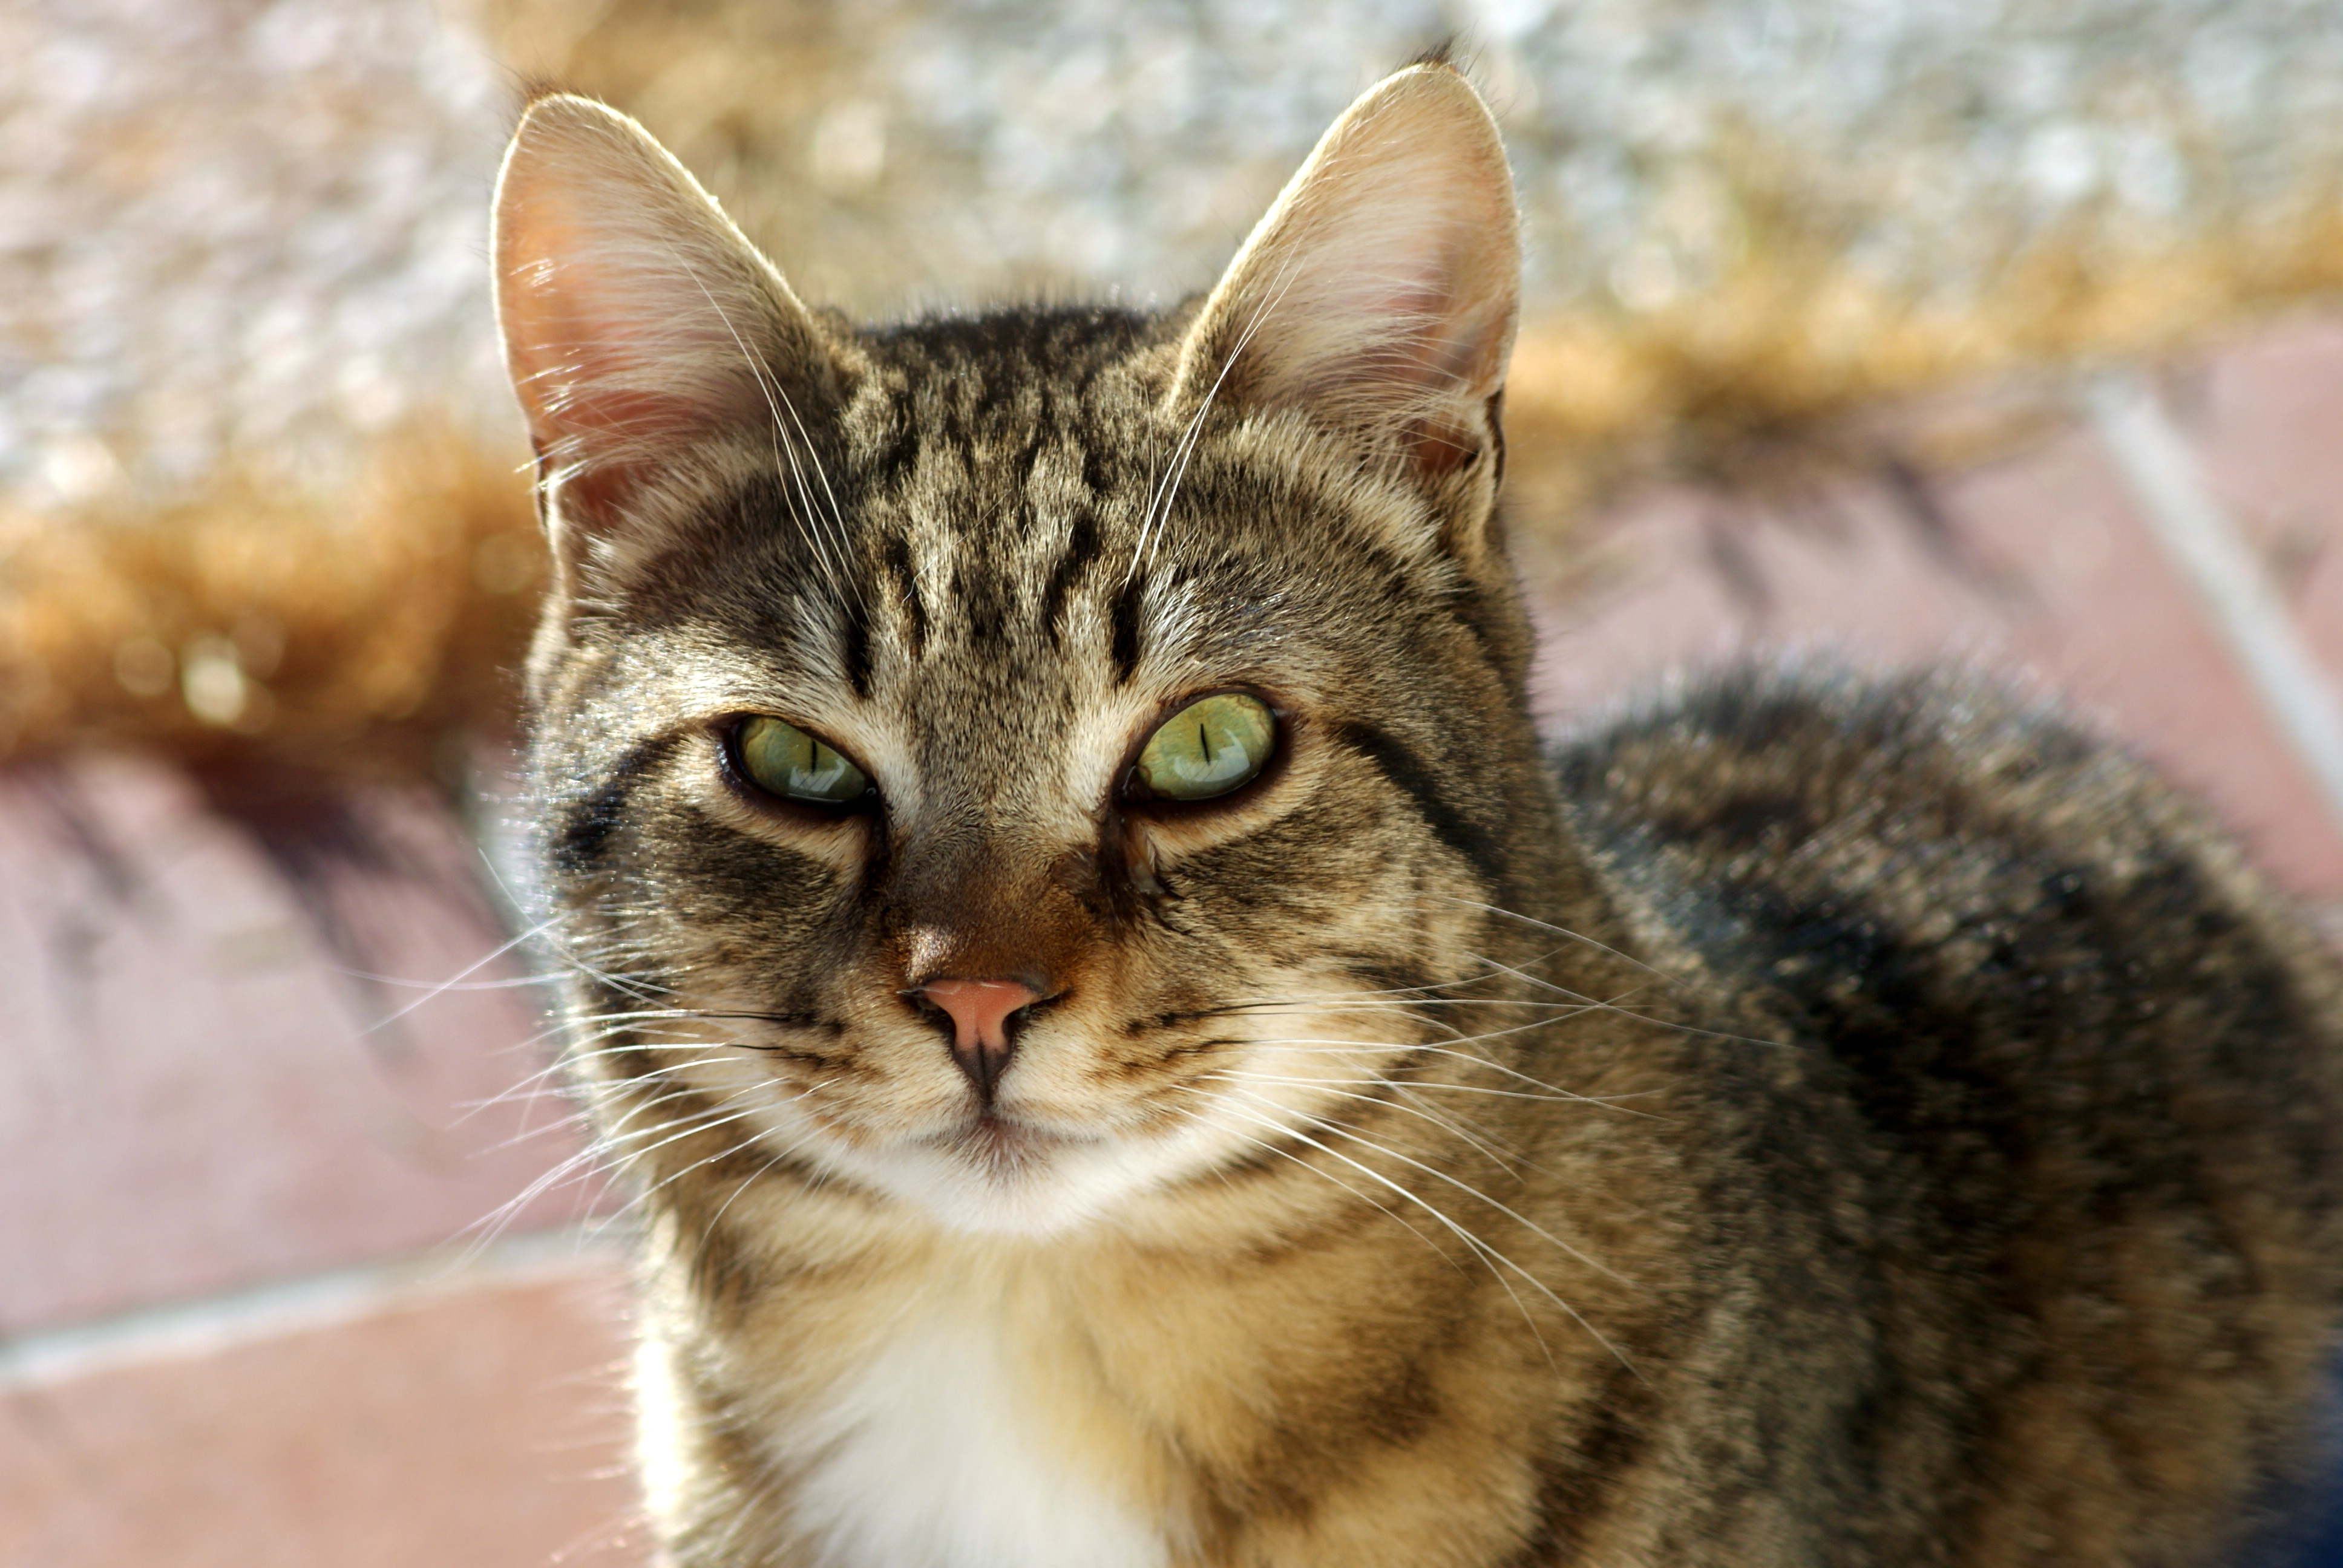

In [3]:
def load_image_data_from_url(url):
    '''
    Function to load image data from online
    '''
    # The local path to our target image
    image_path = keras.utils.get_file(
    "cat.jpg", url
    )

    display(Image(image_path))
    return image_path

image_path = load_image_data_from_url(url = "https://upload.wikimedia.org/wikipedia/commons/7/74/A-Cat.jpg")

In [4]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)

In [5]:
normalized_img[0]

array([[[0.83137256, 0.75686276, 0.69803923],
        [0.8352941 , 0.7607843 , 0.7058824 ],
        [0.83137256, 0.7764706 , 0.7254902 ],
        ...,
        [0.6666667 , 0.7058824 , 0.6627451 ],
        [0.6627451 , 0.6901961 , 0.6627451 ],
        [0.67058825, 0.7058824 , 0.6862745 ]],

       [[0.84705883, 0.77254903, 0.7137255 ],
        [0.84705883, 0.78039217, 0.7176471 ],
        [0.84313726, 0.7882353 , 0.7372549 ],
        ...,
        [0.654902  , 0.6745098 , 0.64705884],
        [0.6509804 , 0.6745098 , 0.6666667 ],
        [0.67058825, 0.7058824 , 0.69411767]],

       [[0.8509804 , 0.7764706 , 0.7176471 ],
        [0.84705883, 0.7882353 , 0.7137255 ],
        [0.83137256, 0.7647059 , 0.7019608 ],
        ...,
        [0.6431373 , 0.6627451 , 0.64705884],
        [0.6745098 , 0.68235296, 0.6627451 ],
        [0.6666667 , 0.7019608 , 0.6901961 ]],

       ...,

       [[0.827451  , 0.69803923, 0.6313726 ],
        [0.8392157 , 0.69803923, 0.6431373 ],
        [0.827451  , 0

In [6]:
from tensorflow.keras.applications.xception import Xception
model = Xception(weights="imagenet")

91884032/91884032 [==============================] - 1s 0us/step


35363/35363 [==============================] - 0s 0us/step
The predicted class is : tabby


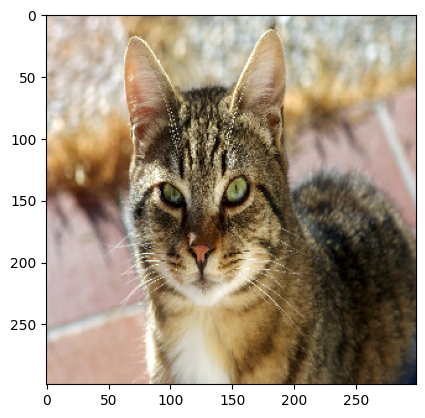

In [7]:
def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")
    return decode_predictions(model_prediction, top=1)[0][0][1]

plt.imshow(normalized_img[0])
pred_orig = get_model_predictions(normalized_img)

In [14]:
model_prediction = model.predict(normalized_img)
top5_pred = decode_predictions(model_prediction, top=5)
for pred in top5_pred:
    print(pred)

1/1 [==============================] - 1s 1s/step
[('n02123045', 'tabby', 0.6019772), ('n02123159', 'tiger_cat', 0.25287703), ('n02124075', 'Egyptian_cat', 0.07189822), ('n02127052', 'lynx', 0.0067606317), ('n02356798', 'fox_squirrel', 0.00045656855)]


In [9]:
explainer = lime_image.LimeImageExplainer()

In [15]:
exp = explainer.explain_instance(normalized_img[0], 
                                 model.predict, 
                                 top_labels=1, 
                                 hide_color=0, 
                                 num_samples=300)

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


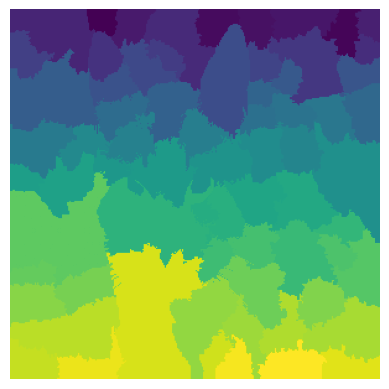

In [16]:
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

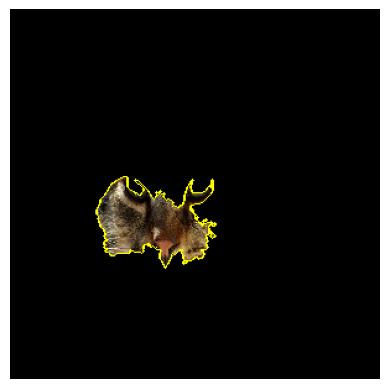

In [17]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

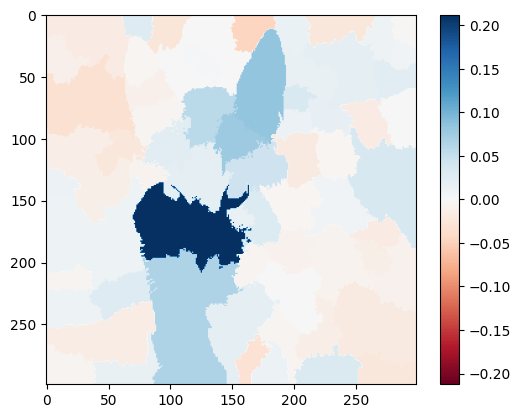

In [18]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])